# Parse simulated barcodes
Simulate some Illumina reads giving barcode counts of variants, parse them from the simulated FASTQ files, and add them to a variant table.
Primarily designed to illustrate how to use an [IlluminaBarcodeParser](https://jbloomlab.github.io/dms_variants/dms_variants.illuminabarcodeparser.html#dms_variants.illuminabarcodeparser.IlluminaBarcodeParser) to parse barcode counts and add them to a [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable).

## Setup for analysis
Import Python modules / packages.
We use [plotnine](https://plotnine.readthedocs.io) for ggplot2-like plotting:

In [1]:
import random
import tempfile
import warnings

import pandas as pd

from plotnine import *

from dms_variants.codonvarianttable import CodonVariantTable
from dms_variants.constants import CBPALETTE
import dms_variants.illuminabarcodeparser
import dms_variants.plotnine_themes
from dms_variants.simulate import (mutate_seq,
                                   rand_seq,
                                   simulate_CodonVariantTable)
from dms_variants.utils import reverse_complement

Seed random number generator:

In [2]:
random.seed(1)

Hide warnings that clutter output:

In [3]:
warnings.simplefilter('ignore')

Set the gray grid [plotnine theme](https://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.theme.html?highlight=themes) defined in [dms_variants.plotnine_themes](https://jbloomlab.github.io/dms_variants/dms_variants.plotnine_themes.html) as this gives a nice appearance for the plots:

In [4]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Create small variant table
We simulate a small [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) for one libraries with three variants, with short 8-nucleotide barcodes.
We simulate the table using using
[simulate_CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulate_CodonVariantTable):

In [5]:
bclen = 8

variants = simulate_CodonVariantTable(
                geneseq=rand_seq(30),
                bclen=bclen,
                library_specs={'lib_1': {'avgmuts': 1.5, 'nvariants': 3}},
                seed=1,
                )

Here are the variants in the simulated table:

In [6]:
variants.barcode_variant_df

,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,lib_1,ATTCCCGT,1,CAG1CTA AGA7GCT,Q1L R7A,2,2
1,lib_1,TACGATTA,1,TCT9AAA,S9K,1,1
2,lib_1,TCACAACC,1,,,0,0


## Simulate barcode reads

We are now going to simulate barcode reads that we will then parse with the [IlluminaBarcodeParser](https://jbloomlab.github.io/dms_variants/dms_variants.illuminabarcodeparser.html#dms_variants.illuminabarcodeparser.IlluminaBarcodeParser).
This parser is designed to parse reads that have this structure:

    5'-[R2_start]-upstream-barcode-downstream-[R1_start]-3'
    
where the R2 read is optional.
Note that we use the convention that the variant table defines the *barcode* sequence in the **orientation read by R1**, which is the reverse complement of the orientation shown in the schematic immediately above.

Here we will simulate a common setup where there is no R2 read, and the *downstream* sequence between the barcode and the R1 start is non-existent (R1 is flush against the barcode).
That means we still have to define an upstream sequence (we'll make this 10 nucleotides long).
We also get the reverse complement of this upstream sequence, which is what is found in the R1 reads:

In [7]:
upstream = rand_seq(10)
upstream_rc = reverse_complement(upstream)
print(f"`upstream` sequence is {upstream}; reverse complement is {upstream_rc}")

`upstream` sequence is CCTGATACGA; reverse complement is TCGTATCAGG


We also simulate how many counts of each barcode we'll have:

In [8]:
simulated_barcode_counts = (
    variants.barcode_variant_df
    [['library', 'barcode']]
    .assign(count=lambda x: [random.randint(0, 2) for _ in range(len(x))])
    )

simulated_barcode_counts

,library,barcode,count
0,lib_1,ATTCCCGT,2
1,lib_1,TACGATTA,1
2,lib_1,TCACAACC,2


Now we simulate the actual Illumina barcode reads that give these counts.
When we parse the barcodes, we'll allow up to one mismatch in the upstream sequence, so sometimes add such a mismatch.
Also, since these reads are in the orientation read by R1, we generate them by adding the barcodes (which we are already representing in the R1 orientation) with the reverse-complement of the *upstream* sequence (since R1 reads into the upstream sequence backwards):

In [9]:
barcode_seqs = []
for tup in simulated_barcode_counts.itertuples():
    for _ in range(tup.count):
        barcode_seqs.append(tup.barcode + mutate_seq(upstream_rc, random.randint(0, 1)))

We will also now add a few sequences that are **not** do not parse to valid barcodes.
First, add a few where the barcode sequence is invalid (not among the true barcodes in the variant table):

In [10]:
n_invalid = 3
valid_barcodes = simulated_barcode_counts['barcode'].tolist()
for _ in range(n_invalid):
    barcode_seqs.append(rand_seq(bclen, exclude=valid_barcodes) + upstream_rc)

Next add a few that are unparseable because the *upstream* sequence has too many mutations to be recognized:

In [11]:
n_unparseable = 2
for _ in range(n_unparseable):
    barcode_seqs.append(random.choice(valid_barcodes) + mutate_seq(upstream_rc, 2))

Finally, we will specify a few low-quality sequences.
First, define the minimum quality score in the barcode region that we will consider acceptable:

In [12]:
minq = 20
minq_char = chr(minq + 33)  # corresponding character for Q score

Add a sufficient quality Q-score string to all the reads in `barcode_seqs`:

In [13]:
barcode_seqs = [(seq, minq_char * len(seq)) for seq in barcode_seqs]

Finally, we add a few sequences with excessively low-quality barcode reads by taking the first few valid entries in `barcode_seqs` and adding a copy with a lower Q-score:

In [14]:
lowq_char = chr(minq + 33 - 1)  # low-quality Q-score
n_low_quality = 1
for seq, q in barcode_seqs[: n_low_quality]:
    barcode_seqs.append((seq, lowq_char + q[1:]))

Finally, we will generate the contents of a FASTQ file holding these sequences.
In order to do that, we need to specify the quality scores for the sequences

In [15]:
fastq_text = '\n'.join([
    f"@read{i + 1}\n{seq}\n+\n{q}" for i, (seq, q) in enumerate(barcode_seqs)
    ])

print(f"Here is the simulated FASTQ file:\n-------------\n{fastq_text}")

Here is the simulated FASTQ file:
-------------
@read1
ATTCCCGTTCGTATCATG
+
555555555555555555
@read2
ATTCCCGTTCGTATCAGG
+
555555555555555555
@read3
TACGATTATCGTTTCAGG
+
555555555555555555
@read4
TCACAACCTCGTATCACG
+
555555555555555555
@read5
TCACAACCTCGTATCAGG
+
555555555555555555
@read6
TCTTCGGATCGTATCAGG
+
555555555555555555
@read7
TACTGTATTCGTATCAGG
+
555555555555555555
@read8
AGTCCCACTCGTATCAGG
+
555555555555555555
@read9
TCACAACCTCGGATCACG
+
555555555555555555
@read10
TACGATTATCGTACCAGC
+
555555555555555555
@read11
ATTCCCGTTCGTATCATG
+
455555555555555555


## Parse barcode reads
Now we initialize a [IlluminaBarcodeParser](https://jbloomlab.github.io/dms_variants/dms_variants.illuminabarcodeparser.html#dms_variants.illuminabarcodeparser.IlluminaBarcodeParser) to parse the barcodes, allowing one mismatch in the upstream sequence (note if we had a *downstream* sequence we could specify it too).
We specify the set of valid barcodes, which we get using the [CodonVariantTable.valid_barcodes](https://jbloomlab.github.io/dms_variants/dms_variants.illuminabarcodeparser.html#dms_variants.illuminabarcodeparser.IlluminaBarcodeParser.valid_barcodes) method of our variant table.
Note that if we had multiple libraries, we'd need a different parser for each one as each would have it's own set of valid barcodes:

In [16]:
parser = dms_variants.illuminabarcodeparser.IlluminaBarcodeParser(
                    bclen=bclen,
                    valid_barcodes=variants.valid_barcodes('lib_1'),
                    upstream=upstream,
                    upstream_mismatch=1,
                    minq=minq)

Now parse the barcodes.
First, write the FASTQ to a temporary file, then parse it.
We add the name of the library and the sample to the parsed data frames.
Then we parse the barcodes using [IlluminaBarcodeParser.parse](https://jbloomlab.github.io/dms_variants/dms_variants.illuminabarcodeparser.html#dms_variants.illuminabarcodeparser.IlluminaBarcodeParser.parse), which returns a 2-tuple of data frames giving the counts of valid barcodes and the fates of all reads that it attempted to parse:

In [17]:
with tempfile.NamedTemporaryFile('r+') as fastq:
    fastq.write(fastq_text)
    fastq.flush()
    counts, fates = parser.parse(r1files=fastq.name,
                                 add_cols={'library': 'lib_1',
                                           'sample': 'sample_1'},
                                 )

Here are the parsed barcode counts:

In [18]:
counts

,barcode,count,library,sample
0,ATTCCCGT,2,lib_1,sample_1
1,TCACAACC,2,lib_1,sample_1
2,TACGATTA,1,lib_1,sample_1


Here are the fates of the reads we attempted to parse:

In [19]:
fates

,fate,count,library,sample
0,valid barcode,5,lib_1,sample_1
1,invalid barcode,3,lib_1,sample_1
2,unparseable barcode,2,lib_1,sample_1
3,low quality barcode,1,lib_1,sample_1
4,failed chastity filter,0,lib_1,sample_1


## Add barcodes to variant table
We add the barcodes `count` data frame to the variant table using [CodonVariantTable.add_sample_counts_df](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.add_sample_counts_df):

In [20]:
variants.add_sample_counts_df(counts)

print(f"Here are the counts added to the variant table:")
variants.variant_count_df

Here are the counts added to the variant table:


,barcode,count,library,sample,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,ATTCCCGT,2,lib_1,sample_1,1,CAG1CTA AGA7GCT,Q1L R7A,2,2
1,TCACAACC,2,lib_1,sample_1,1,,,0,0
2,TACGATTA,1,lib_1,sample_1,1,TCT9AAA,S9K,1,1


Make sure these counts are as expected from the simulation parameters:

In [21]:
pd.testing.assert_frame_equal(
        simulated_barcode_counts.sort_values('barcode').reset_index(drop=True),
        (variants.variant_count_df[['library', 'barcode', 'count']]
         .sort_values('barcode').reset_index(drop=True))
        )

## Look at the barcode-read fates
Now we look in more detail at the barcode-read `fates` data frame that tells what happened to the barcode reads.
First, we make sure the correct number of reads fall in each category based on the simulation parameters:

In [22]:
pd.testing.assert_frame_equal(
        fates[['fate', 'count']],
        pd.DataFrame([('valid barcode', simulated_barcode_counts['count'].sum()),
                      ('invalid barcode', n_invalid),
                      ('unparseable barcode', n_unparseable),
                      ('low quality barcode', n_low_quality),
                      ('failed chastity filter', 0)
                      ],
                     columns=['fate', 'count'])
        )

Now plot the barcode-read fates using [plotnine](https://plotnine.readthedocs.io) for ggplot2-like plotting.
The plot below shows the valid barcodes in orange and all others in gray:

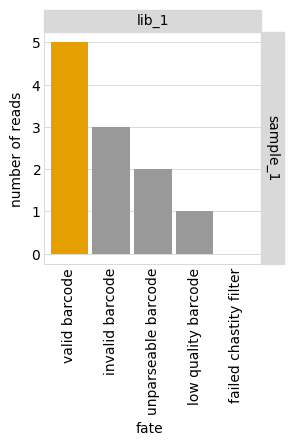

In [23]:
barcode_fate_plot = (
    ggplot(
        fates
        .assign(sample=lambda x: pd.Categorical(x['sample'],
                                                x['sample'].unique(),
                                                ordered=True),
                fate=lambda x: pd.Categorical(x['fate'],
                                              x['fate'].unique(),
                                              ordered=True),
                is_valid=lambda x: x['fate'] == 'valid barcode'
                ), 
        aes('fate', 'count', fill='is_valid')) +
    geom_bar(stat='identity') +
    facet_grid('sample ~ library') +
    facet_grid('sample ~ library') +
    scale_fill_manual(CBPALETTE, guide=False) +
    theme(figure_size=(1.4 * (1 + len(fates['library'].unique())),
                       1.4 * (1.2 + len(fates['sample'].unique()))),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank()
          ) +
    scale_y_continuous(labels=dms_variants.utils.latex_sci_not,
                       name='number of reads')
    )

_ = barcode_fate_plot.draw()